In [1]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.stimuli import PatchStimulusGenerator
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION

In [2]:
reference_positions = [(105, 100)]

def plot_generator_examples(generator, ref_pos=reference_positions):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((80, 100 + (i * 20)), ref_pos, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

def plot_triplets(triplets):
    n = triplets.shape[0]
    k = triplets.shape[1]

    plt.figure(figsize=(2.5 * k, 3 * n))

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

    plt.show()

In [3]:
def make_color_bar_gen(target_size=15, reference_size = (10, 100), rotate_angle=None):

    blue_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='blue')
    red_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='red')
    green_target_patch = matplotlib.patches.Circle((0, 0), target_size // 2, color='green')
    reference_patch = matplotlib.patches.Ellipse((0, 0), width=reference_size[1], 
                                                height=reference_size[0], color='black')

    blur_func = lambda x: cv2.blur(x, (5, 5))

    return PatchStimulusGenerator(target_size, reference_size, [blue_target_patch, red_target_patch, green_target_patch], 
                                reference_patch, blur_func=blur_func, rotate_angle=rotate_angle)


def make_split_text_gen(target_size=(15, 15), reference_box_size=8, n_reference_patches=7,
    total_reference_size=(10, 140), rotate_angle=None):
    
    triangle_patch = matplotlib.patches.RegularPolygon((0, 0), 3, target_size[0] // 2, color='black')

    reference_patches = [matplotlib.patches.Rectangle(((-reference_box_size // 2) + (reference_box_size * 2 * i), 
                                                    (-reference_box_size // 2)), 
                                                    reference_box_size, reference_box_size, color='black')
                        for i in range(n_reference_patches)]


    return PatchStimulusGenerator(target_size, total_reference_size, 
        ['E', '$+$', triangle_patch, 's', '$\\to$'], 
        reference_patches, rotate_angle=rotate_angle,
        )


# Stimulus conditions we have
* Above/below
    * With two reference objects
        * With or without a gap between them
* Between
* *The above two relations, but sideways (left/right and vertical between)* -- currently not plotted because it's just the regular stimuli transposed, but I can add that demo.
* Diagonal
* With both generators above



# Above/Below

## color bar | above_below | one ref

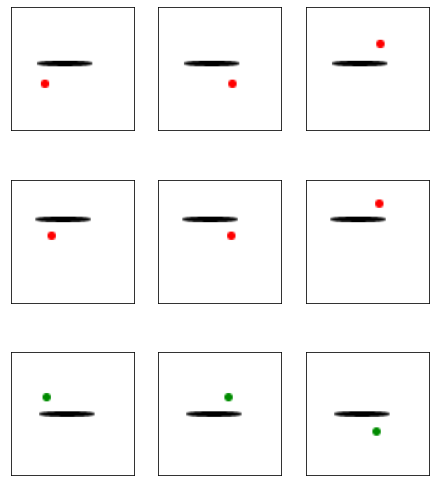

----

## split text | above_below | one ref

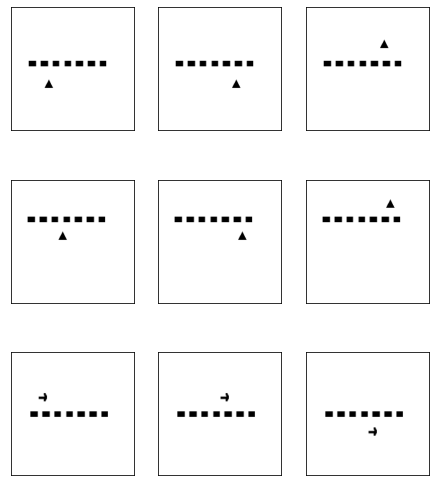

----

## color bar | above_below | two refs | non-adjacent refs

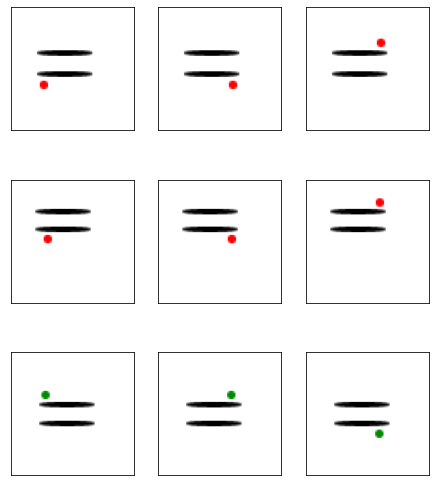

----

## split text | above_below | two refs | non-adjacent refs

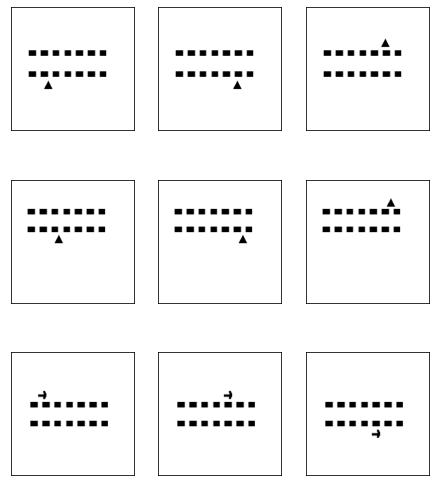

----

## color bar | above_below | two refs | adjacent refs

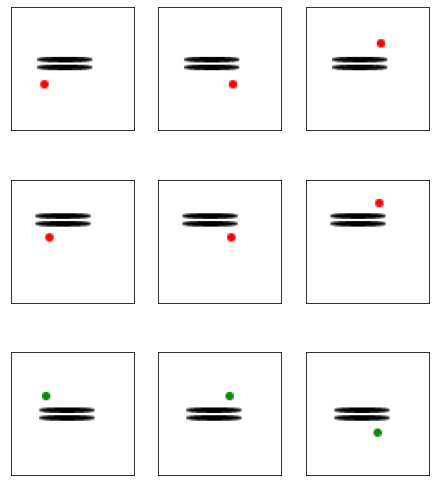

----

## split text | above_below | two refs | adjacent refs

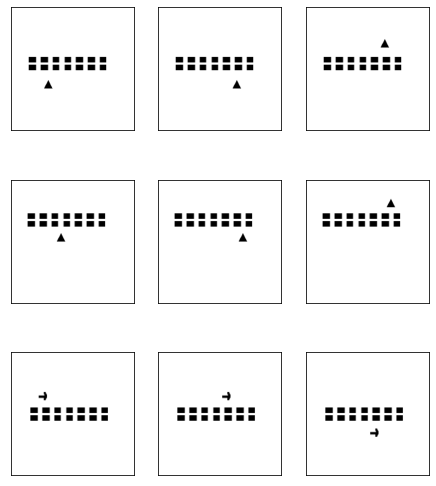

----

In [6]:
relation = ABOVE_BELOW_RELATION
distance_endpoints_dict = {
    (False, False): (30, 80),
    (True, False): (50, 80),
    (True, True): (40, 80),  
}
N_examples = 3

display(Markdown('# Above/Below'))

for two_reference_objects in (False, True):
    for adjacent_reference_objects in (False, True):
        if not two_reference_objects and adjacent_reference_objects:
            continue

        distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

        for stimulus_generator, generator_name in \
            zip((make_color_bar_gen(), make_split_text_gen()), ('color bar', 'split text')):
            
            triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
                relation=relation, two_reference_objects=two_reference_objects,
                adjacent_reference_objects=adjacent_reference_objects)

            adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
            title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
            display(Markdown(f'## {title}'))
            triplets = triplet_generator(N_examples, normalize=False)
            plot_triplets(triplets)
            display(Markdown('----'))


# Between/Outside

## color bar | between

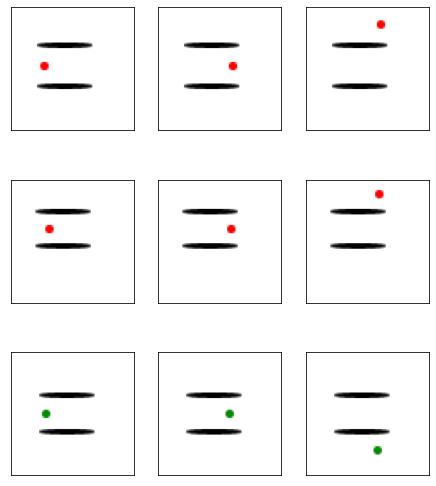

----

## split text | between

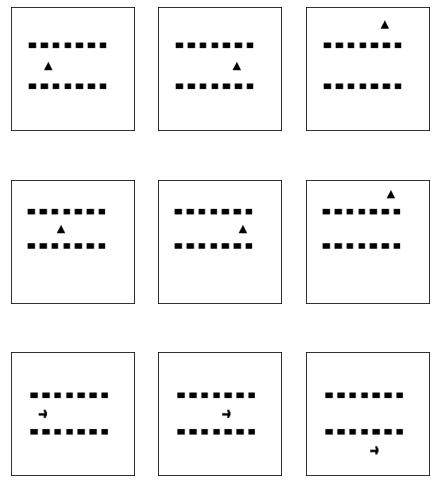

----

In [7]:
relation = BETWEEN_RELATION
distance_endpoints = (30, 80)
N_examples = 3

display(Markdown('# Between/Outside'))

distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for stimulus_generator, generator_name in \
    zip((make_color_bar_gen(), make_split_text_gen()), ('color bar', 'split text')):
    
    triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
        relation=relation, two_reference_objects=True,
        adjacent_reference_objects=False)

    # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
    # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
    title = f'{generator_name} | {relation}'
    display(Markdown(f'## {title}'))
    triplets = triplet_generator(N_examples, normalize=False)
    plot_triplets(triplets)
    display(Markdown('----'))


# Diagonal Above/Below

## color bar | above_below

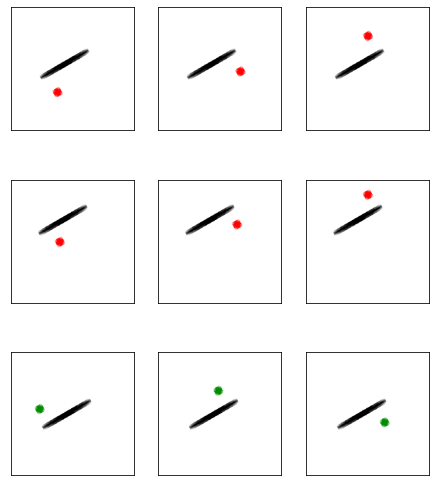

----

## split text | above_below

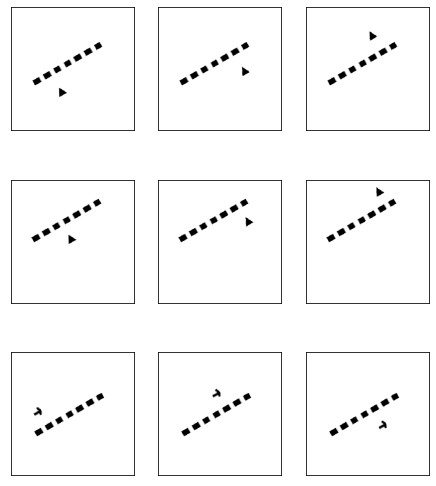

----

## color bar | above_below

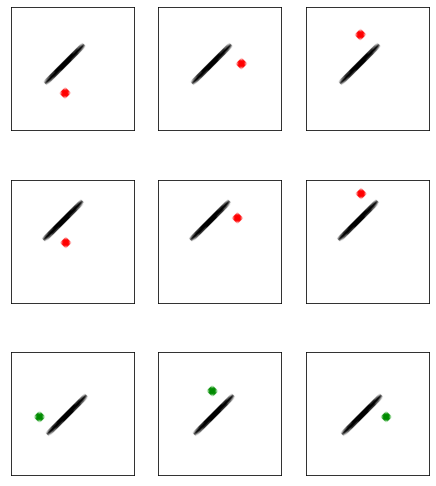

----

## split text | above_below

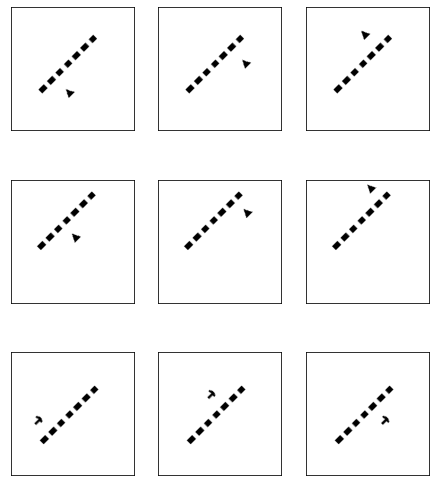

----

## color bar | above_below

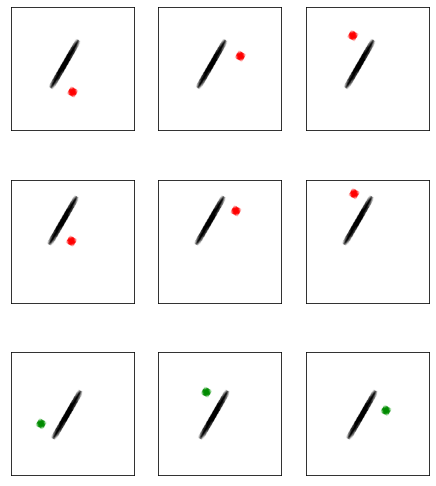

----

## split text | above_below

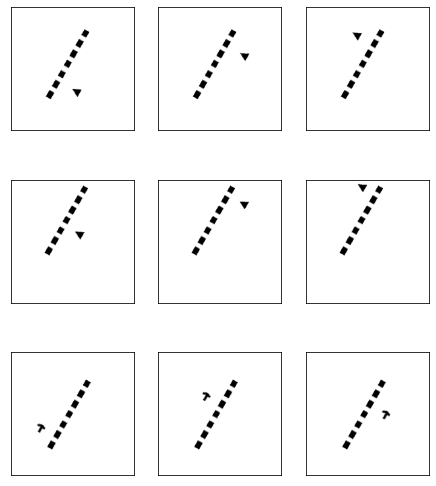

----

In [8]:
relation = ABOVE_BELOW_RELATION
distance_endpoints = (30, 80)
N_examples = 3

display(Markdown('# Diagonal Above/Below'))

distance_endpoints = distance_endpoints_dict[(two_reference_objects, adjacent_reference_objects)]

for rotate_angle in (30, 45, 60):
    for stimulus_generator, generator_name in \
        zip((make_color_bar_gen(rotate_angle=rotate_angle), make_split_text_gen(rotate_angle=rotate_angle)), ('color bar', 'split text')):
        
        triplet_generator = QuinnTripletGenerator(stimulus_generator, distance_endpoints,
            relation=relation, two_reference_objects=False,
            adjacent_reference_objects=False)

        # adj_str = 'adjacent refs' if adjacent_reference_objects else ('non-adjacent refs' if two_reference_objects else '')
        # title = f'{generator_name} | {relation} | {"two refs" if two_reference_objects else "one ref"}{" | " if adj_str else ""}{adj_str}'
        title = f'{generator_name} | {relation}'
        display(Markdown(f'## {title}'))
        triplets = triplet_generator(N_examples, normalize=False)
        plot_triplets(triplets)
        display(Markdown('----'))


Note for the above: we could obviously run all of the different variations of above/below (two reference objects, what sort of gap betwen them, etc.) on the diagonal case as well, if we wanted to.

Similarly, we could run between/outside diagonally, too.

Not plotted but also exist are the left/right and vertical between stimuli, which are just the non-diagonal stimuli transposed. 

Let me know if you want me to plot any of the above.

### TODO:
Two significant things are still missing here:
1. In the paper I had a condition where I sampled random colors for each object, which I still need to port to my revised code.
2. I haven't finished implementing the condition where we create more than one habituation stimulus.